# Before Modeling

> Model selection
1. 엘라스틱 - Ridge, Lasso 합친거니까 선택
2. randomForest - 트리모형
3. lightgbm - 트리모형
4. xgboost - 트리모형

## Data

In [1]:
import pandas as pd
data = pd.read_excel('Movie_Data_Final_transformation.xlsx').iloc[:,1:]

In [2]:
# modeling에 포함되지 않는 columns 제거
colums_rm = ['movie_name','release', 'take', 'code', 'kind', 'scale', 'actor']
def remove_columns(movie_df):
    col = list(movie_df.columns)
    for i in colums_rm:
        col.remove(i)
    movie_df = movie_df.loc[:, col]
    
    return movie_df

In [3]:
# 영화명 날림
data = remove_columns(data)

In [4]:
data.to_excel('Modeling_Movie_Data.xlsx')

## import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import ElasticNet, ElasticNetCV # 두 개 구분
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## One-hot encoding

In [6]:
data = pd.get_dummies(data = data, columns = ['nation'], prefix = 'nation')
data = pd.get_dummies(data = data, columns = ['distribution_company'], prefix = 'distribution_company')
data = pd.get_dummies(data = data, columns = ['genre'], prefix = 'genre')
data = pd.get_dummies(data = data, columns = ['age'], prefix = 'age')

In [7]:
x = data.iloc[:,1:] 
y = np.log(data.iloc[:,0]) # 관객수 log transformation

# Modeling

> 결과
- ElasticNet Final Result: MSE:0.43, RMSE:0.66
- RandomForest Final Result: MSE:0.42 RMSE:0.65
- Lightgbm Final Result: MSE:0.47, RMSE:0.69
- xgboost Final Result: MSE:0.45, RMSE:0.67


In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=0)

## ElasticNet

In [9]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

# R2는 제일 높고 (제일 설명력이 좋고), RMSE는 제일 낮은 값 선택
for a in alphas:
    model = ElasticNet(alpha=a).fit(x,y)
    score = model.score(x, y)
    pred_y = model.predict(x)
    mse = mean_squared_error(y, pred_y)
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:0.68, MSE:0.31, RMSE:0.56
Alpha:0.0010, R2:0.68, MSE:0.31, RMSE:0.56
Alpha:0.0100, R2:0.62, MSE:0.38, RMSE:0.61
Alpha:0.1000, R2:0.56, MSE:0.43, RMSE:0.65
Alpha:0.3000, R2:0.54, MSE:0.45, RMSE:0.67
Alpha:0.5000, R2:0.54, MSE:0.45, RMSE:0.67
Alpha:0.7000, R2:0.54, MSE:0.45, RMSE:0.67
Alpha:1.0000, R2:0.54, MSE:0.45, RMSE:0.67


In [10]:
elastic_cv= ElasticNetCV(alphas=alphas, cv=5) # 교차검증 5번
model = elastic_cv.fit(x, y)
print(model.alpha_)

0.1


In [11]:
elastic = ElasticNet(alpha=0.1).fit(xtrain, ytrain)
ypred_elastic = elastic.predict(xtest)

# calculate R2, MSE, RMSE from test data
score_elastic = elastic.score(xtest, ytest)
mse_elastic = mean_squared_error(ytest, ypred_elastic)
print("ElasticNet Final Result: R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}".format(score_elastic, mse_elastic, np.sqrt(mse_elastic)))

ElasticNet Final Result: R2:0.541, MSE:0.43, RMSE:0.66


## RandomForest

In [ ]:
RandomForestRegressor?

In [12]:
nTreeList = range(50, 500, 10)
nTree = []
MSE = []

for iTrees in nTreeList:
    randomforest = RandomForestRegressor(n_estimators=iTrees, random_state=3)
    randomforest.fit(xtrain, ytrain)  
    ypred = randomforest.predict(xtest)
    nTree.append(iTrees)
    MSE.append(mean_squared_error(ytest, ypred))
    
# 결정트리 갯수 무작정 늘리면 성능 좋아지는데 대비 시간이 걸릴 수 있음
index = MSE.index(min(MSE))
print(index)
print(nTree[index])

44
490


In [13]:
randomforest = RandomForestRegressor(n_estimators=490, random_state=3)
randomforest.fit(xtrain, ytrain)
ypred_randomforest= randomforest.predict(xtest)

# calculate RMSE from test data
mse_randomforest = mean_squared_error(ytest, ypred_randomforest)
print("RandomForest Final Result: MSE:{0:.2f} RMSE:{1:.2f}".format(mse_randomforest, np.sqrt(mse_randomforest)))
featureImportance = randomforest.feature_importances_

RandomForest Final Result: MSE:0.42 RMSE:0.65


In [ ]:
# #가장 높은 중요도 기준으로 스케일링
# featureImportance = featureImportance/featureImportance.max()
# sorted_idx = np.argsort(featureImportance)
# barPos = np.arange(sorted_idx.shape[0])+.5
# plt.barh(barPos, featureImportance[sorted_idx], align='center')
# plt.yticks(barPos, x.columns[sorted_idx])
# plt.xlabel('Variable Importance')
# plt.show()

## lightgbm

In [14]:
train_ds = lgb.Dataset(xtrain, label = ytrain) 
test_ds = lgb.Dataset(xtest, label = ytest) 

params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':3}

In [15]:
lgb_model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 152, number of used features: 13
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 14.596463
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [16]:
predict_train = lgb_model.predict(xtrain)
ypred_lgb = lgb_model.predict(xtest)

In [17]:
# calculate MSE, RMSE from test data
mse_lgb = mean_squared_error(ytest, ypred_lgb )
print("Lightgbm Final Result: MSE:{0:.2f}, RMSE:{1:.2f}".format(mse_lgb, np.sqrt(mse_lgb)))

Lightgbm Final Result: MSE:0.47, RMSE:0.69


In [18]:
final_result = pd.concat([ytest.reset_index(drop=True), pd.DataFrame(ypred_lgb )], axis = 1)
final_result.columns = ['ytest','ypred']

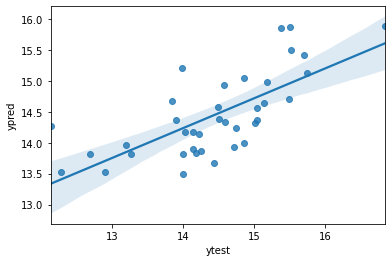

In [20]:
# Fit 결과 확인
sns.regplot(x = 'ytest', y = 'ypred', data = final_result)

## xgboost

In [21]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75, colsample_bytree=1, max_depth=7)

xgb_model.fit(xtrain,ytrain)
ypred_xgb = xgb_model.predict(xtest)

In [22]:
# calculate MSE, RMSE from test data
mse_xgb = mean_squared_error(ytest, ypred_xgb)
print("xgboost Final Result: MSE:{0:.2f}, RMSE:{1:.2f}".format(mse_xgb, np.sqrt(mse_xgb)))

xgboost Final Result: MSE:0.45, RMSE:0.67


<Figure size 720x720 with 0 Axes>

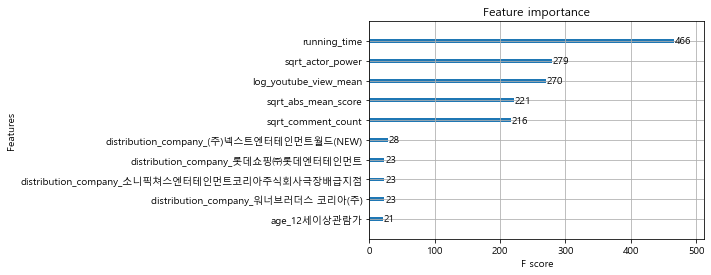

In [29]:
plt.figure(figsize=(10,10))
plt.rcParams['font.family'] ='Malgun Gothic'
xgb.plot_importance(xgb_model, max_num_features= 10)
plt.show()